In [1]:
import sys
sys.path.append("../")

import torch

from tdoa.visualization import plot_mics_and_sources
from neural_tdoa.model import TdoaCrnn
from neural_tdoa.utils.load_config import load_config
from datasets.dataset import TdoaDataset
from datasets.visualization import plot_microphone_signals


def load_model():
    model = TdoaCrnn()
    
    weights = torch.load("../tests/fixtures/weights.pth",
                         map_location=torch.device('cpu'))["state_dict"]
    weights = {
        k.replace("model.", ""): v for k, v in weights.items()
    }
    
    model.load_state_dict(weights)
    model.eval()

    return model

def eval_model(model, x):
    with torch.no_grad():
        return model(x)

model = load_model()
config = load_config()
dataset = TdoaDataset(config["test_dataset"])

  0%|                                                                                              | 0/50 [00:00<?, ?it/s]

dataset directory does not exist. Generating new dataset


100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.63it/s]


  0%|                                                                                              | 0/50 [00:00<?, ?it/s]

Prediction 0.46274539828300476, Error: 0.1652715504169464


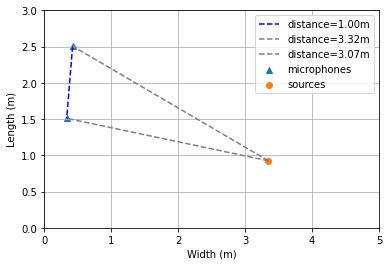

  2%|█▋                                                                                    | 1/50 [00:00<00:42,  1.14it/s]

Prediction 0.1510438323020935, Error: 0.11338100582361221


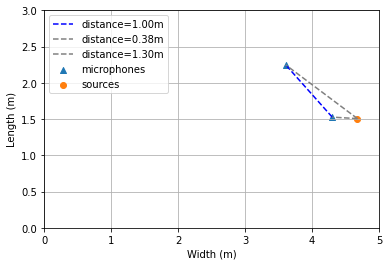

  4%|███▍                                                                                  | 2/50 [00:01<00:39,  1.22it/s]

Prediction 0.7723297476768494, Error: 0.08641606569290161


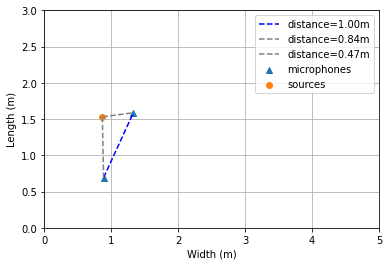

  6%|█████▏                                                                                | 3/50 [00:02<00:40,  1.17it/s]

Prediction 0.371879518032074, Error: 0.16209529340267181


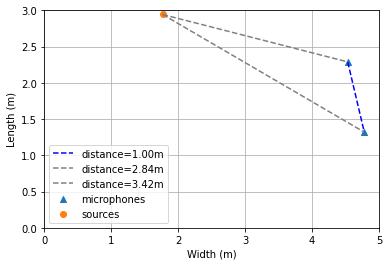

  8%|██████▉                                                                               | 4/50 [00:03<00:37,  1.23it/s]

Prediction 0.45894911885261536, Error: 0.45745257451198995


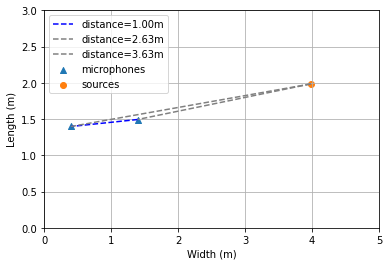

 10%|████████▌                                                                             | 5/50 [00:04<00:34,  1.29it/s]

Prediction 0.5389418005943298, Error: 0.062403321266174316


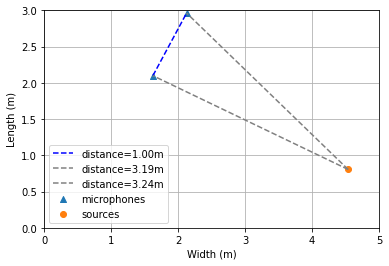

 12%|██████████▎                                                                           | 6/50 [00:04<00:33,  1.33it/s]

Prediction 0.6818948984146118, Error: 0.28400689363479614


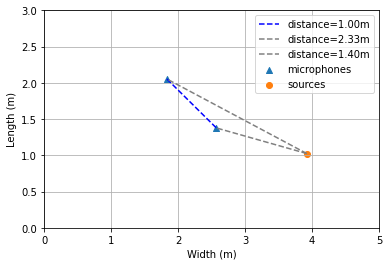

 14%|████████████                                                                          | 7/50 [00:05<00:28,  1.51it/s]

Prediction 0.6954543590545654, Error: 0.1516488790512085


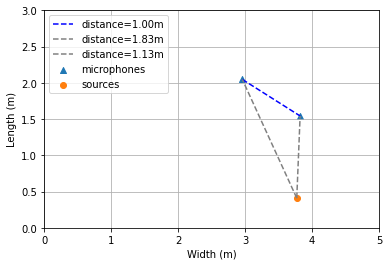

 16%|█████████████▊                                                                        | 8/50 [00:05<00:25,  1.68it/s]

Prediction 0.18516984581947327, Error: 0.17997561860829592


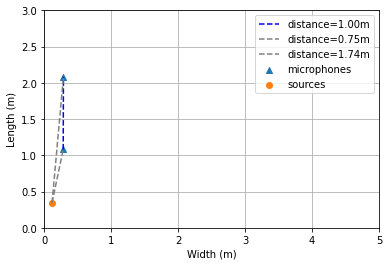

 18%|███████████████▍                                                                      | 9/50 [00:06<00:24,  1.68it/s]

Prediction 0.3100629448890686, Error: 0.30918967188335955


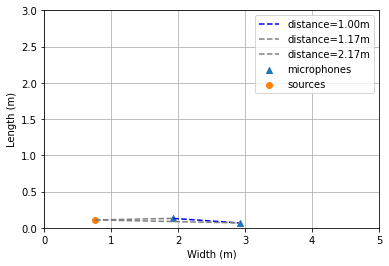

 20%|█████████████████                                                                    | 10/50 [00:06<00:22,  1.74it/s]

Prediction 0.45527955889701843, Error: 0.0831013023853302


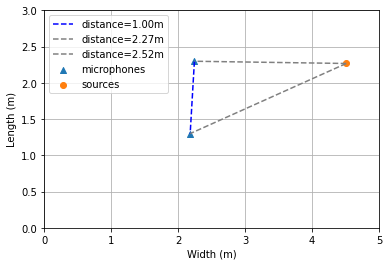

 22%|██████████████████▋                                                                  | 11/50 [00:07<00:21,  1.83it/s]

Prediction 0.5831186771392822, Error: 0.1619601547718048


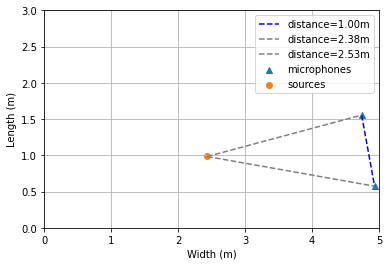

 24%|████████████████████▍                                                                | 12/50 [00:07<00:20,  1.85it/s]

Prediction 0.6218595504760742, Error: 0.36057960987091064


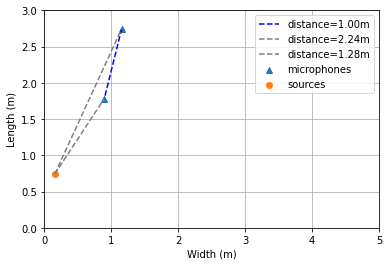

 26%|██████████████████████                                                               | 13/50 [00:08<00:19,  1.91it/s]

Prediction 0.4418781101703644, Error: 0.0415615439414978


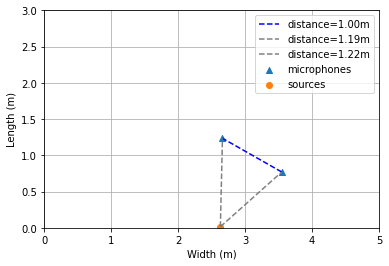

 28%|███████████████████████▊                                                             | 14/50 [00:08<00:18,  1.95it/s]

Prediction 0.6035722494125366, Error: 0.05437588691711426


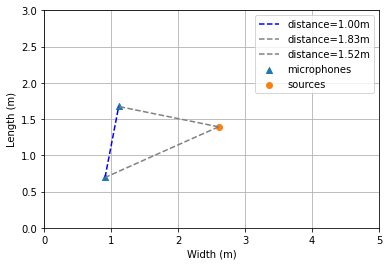

 30%|█████████████████████████▌                                                           | 15/50 [00:09<00:17,  1.95it/s]

Prediction 0.19243891537189484, Error: 0.19239430552261183


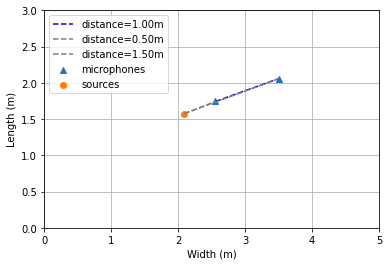

 32%|███████████████████████████▏                                                         | 16/50 [00:09<00:17,  1.94it/s]

Prediction 0.4407026171684265, Error: 0.15373000502586365


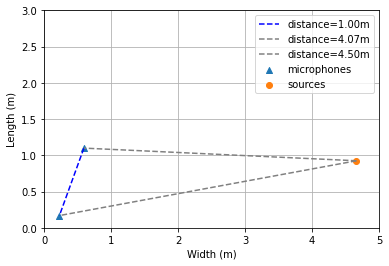

 34%|████████████████████████████▉                                                        | 17/50 [00:10<00:16,  1.95it/s]

Prediction 0.6764630079269409, Error: 0.06281167268753052


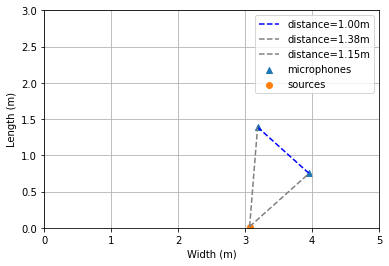

 36%|██████████████████████████████▌                                                      | 18/50 [00:10<00:16,  1.93it/s]

Prediction 0.24931678175926208, Error: 0.2423594598658383


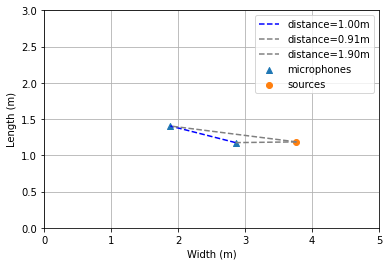

 38%|████████████████████████████████▎                                                    | 19/50 [00:11<00:16,  1.91it/s]

Prediction 0.6334759593009949, Error: 0.3061631917953491


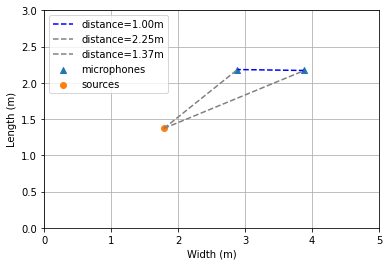

 40%|██████████████████████████████████                                                   | 20/50 [00:11<00:15,  1.95it/s]

Prediction 0.32772573828697205, Error: 0.00017076730728149414


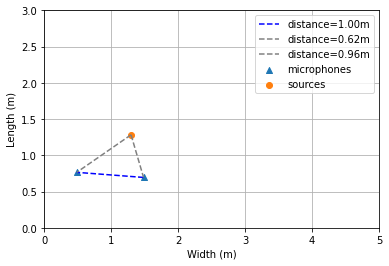

 42%|███████████████████████████████████▋                                                 | 21/50 [00:12<00:15,  1.93it/s]

Prediction 0.45042291283607483, Error: 0.012515366077423096


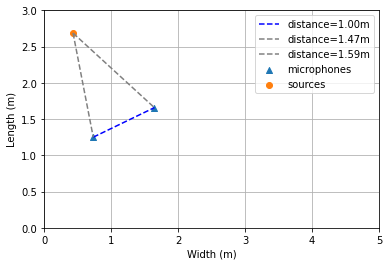

 44%|█████████████████████████████████████▍                                               | 22/50 [00:12<00:14,  1.92it/s]

Prediction 0.5747014880180359, Error: 0.42319510877132416


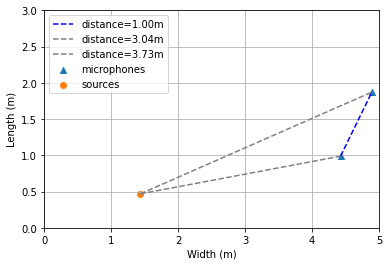

 46%|███████████████████████████████████████                                              | 23/50 [00:13<00:14,  1.92it/s]

Prediction 0.6274623274803162, Error: 0.09014272689819336


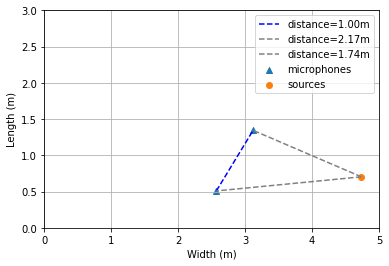

 48%|████████████████████████████████████████▊                                            | 24/50 [00:13<00:13,  1.96it/s]

Prediction 0.4708661139011383, Error: 0.12315815687179565


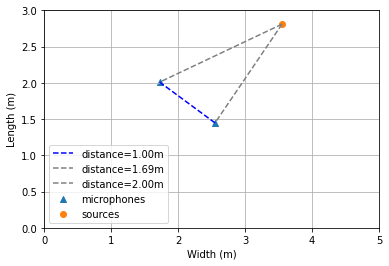

 50%|██████████████████████████████████████████▌                                          | 25/50 [00:14<00:13,  1.79it/s]

Prediction 0.5104197263717651, Error: 0.3176547586917877


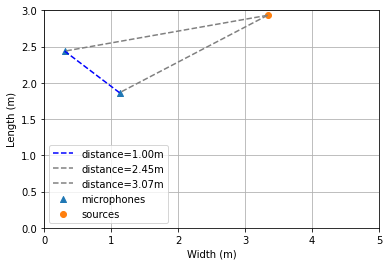

 52%|████████████████████████████████████████████▏                                        | 26/50 [00:15<00:12,  1.92it/s]

Prediction 0.33749011158943176, Error: 0.2165207415819168


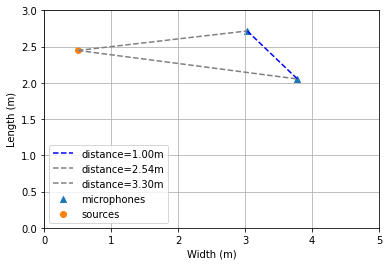

 54%|█████████████████████████████████████████████▉                                       | 27/50 [00:15<00:11,  1.92it/s]

Prediction 0.1871487945318222, Error: 0.024272024631500244


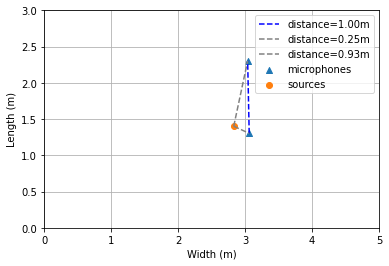

 56%|███████████████████████████████████████████████▌                                     | 28/50 [00:16<00:11,  1.93it/s]

Prediction 0.5947977900505066, Error: 0.2514086365699768


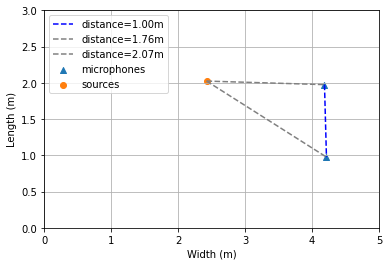

 58%|█████████████████████████████████████████████████▎                                   | 29/50 [00:16<00:10,  1.95it/s]

Prediction 0.6988958716392517, Error: 0.3002605438232422


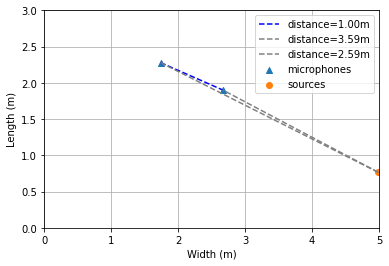

 60%|███████████████████████████████████████████████████                                  | 30/50 [00:17<00:10,  1.97it/s]

Prediction 0.5848643779754639, Error: 0.061769187450408936


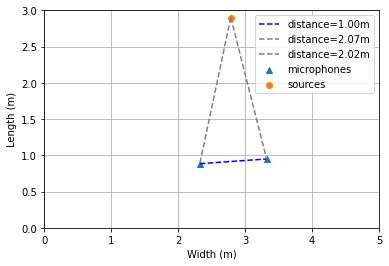

 62%|████████████████████████████████████████████████████▋                                | 31/50 [00:17<00:09,  2.04it/s]

Prediction 0.5958423614501953, Error: 0.17019927501678467


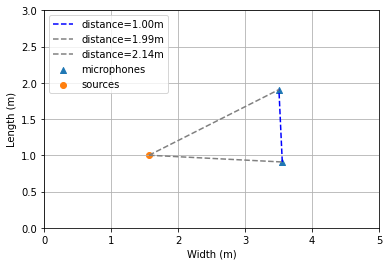

 64%|██████████████████████████████████████████████████████▍                              | 32/50 [00:17<00:08,  2.06it/s]

Prediction 0.6243247389793396, Error: 0.33824437856674194


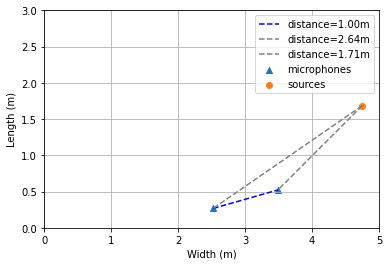

 66%|████████████████████████████████████████████████████████                             | 33/50 [00:18<00:08,  2.02it/s]

Prediction 0.7272796630859375, Error: 0.08652675151824951


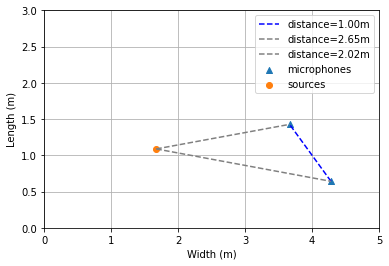

 68%|█████████████████████████████████████████████████████████▊                           | 34/50 [00:19<00:08,  1.99it/s]

Prediction 0.5723678469657898, Error: 0.10071873664855957


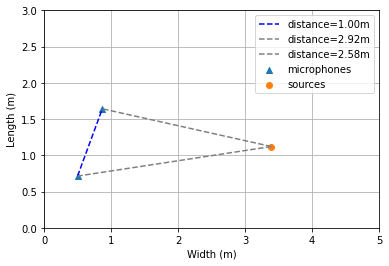

 70%|███████████████████████████████████████████████████████████▍                         | 35/50 [00:19<00:07,  2.04it/s]

Prediction 0.9153921604156494, Error: 0.006234288215637207


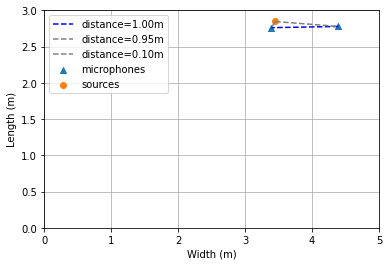

 72%|█████████████████████████████████████████████████████████████▏                       | 36/50 [00:20<00:07,  1.97it/s]

Prediction 0.6391299962997437, Error: 0.0863378643989563


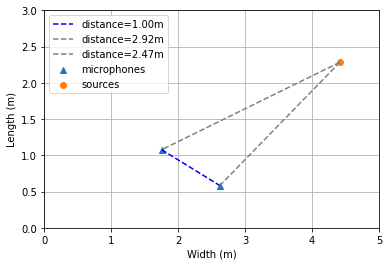

 74%|██████████████████████████████████████████████████████████████▉                      | 37/50 [00:20<00:06,  1.96it/s]

Prediction 0.4804556667804718, Error: 0.14566680788993835


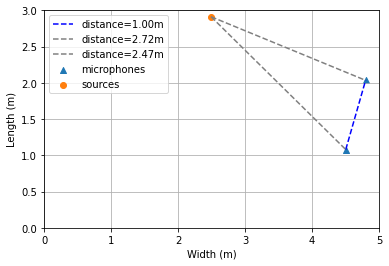

 76%|████████████████████████████████████████████████████████████████▌                    | 38/50 [00:21<00:06,  1.94it/s]

Prediction 0.28856128454208374, Error: 0.18352863937616348


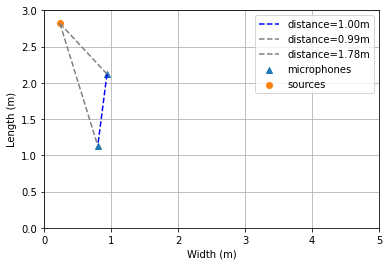

 78%|██████████████████████████████████████████████████████████████████▎                  | 39/50 [00:21<00:05,  1.97it/s]

Prediction 0.17389827966690063, Error: 0.08647993206977844


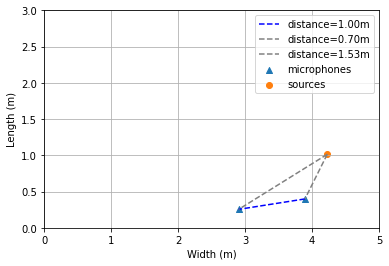

 80%|████████████████████████████████████████████████████████████████████                 | 40/50 [00:22<00:04,  2.02it/s]

Prediction 0.4626389443874359, Error: 0.2687421441078186


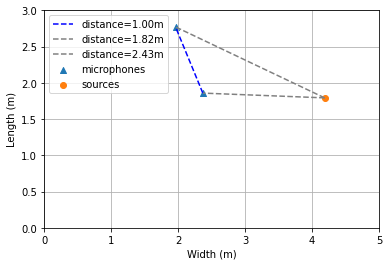

 82%|█████████████████████████████████████████████████████████████████████▋               | 41/50 [00:22<00:04,  1.81it/s]

Prediction 0.5883944630622864, Error: 0.4119677245616913


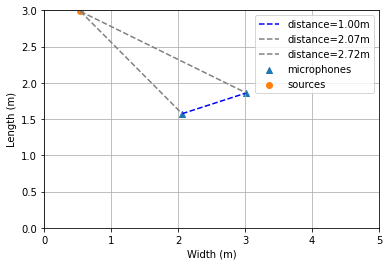

 84%|███████████████████████████████████████████████████████████████████████▍             | 42/50 [00:23<00:04,  1.84it/s]

Prediction 0.4259640872478485, Error: 0.33126862347126007


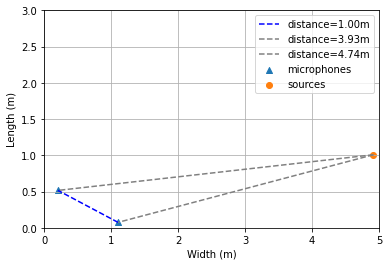

 86%|█████████████████████████████████████████████████████████████████████████            | 43/50 [00:23<00:03,  1.85it/s]

Prediction 0.5735455751419067, Error: 0.41294610500335693


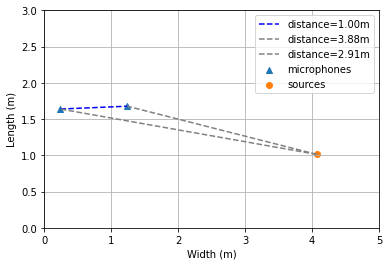

 88%|██████████████████████████████████████████████████████████████████████████▊          | 44/50 [00:24<00:03,  1.90it/s]

Prediction 0.5351446270942688, Error: 0.1372477114200592


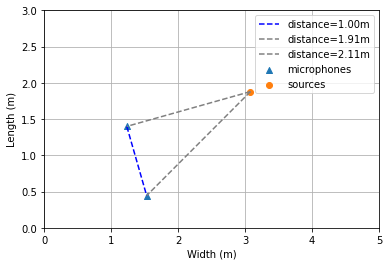

 90%|████████████████████████████████████████████████████████████████████████████▌        | 45/50 [00:24<00:02,  1.89it/s]

Prediction 0.12669850885868073, Error: 0.09613648988306522


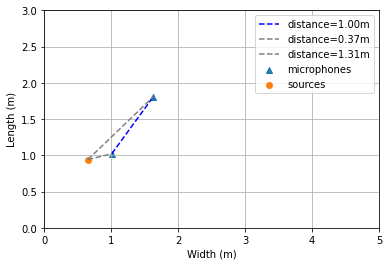

 92%|██████████████████████████████████████████████████████████████████████████████▏      | 46/50 [00:25<00:02,  1.91it/s]

Prediction 0.7532387971878052, Error: 0.24420344829559326


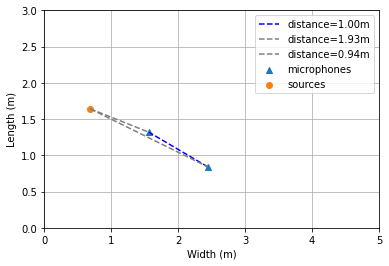

 94%|███████████████████████████████████████████████████████████████████████████████▉     | 47/50 [00:25<00:01,  1.93it/s]

Prediction 0.4975903630256653, Error: 0.051745057106018066


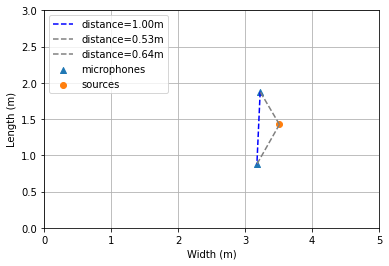

 96%|█████████████████████████████████████████████████████████████████████████████████▌   | 48/50 [00:26<00:01,  1.95it/s]

Prediction 0.7903085350990295, Error: 0.11626595258712769


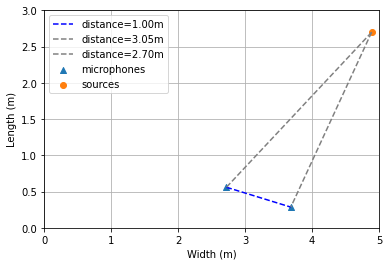

 98%|███████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:26<00:00,  1.93it/s]

Prediction 0.6122852563858032, Error: 0.25519463419914246


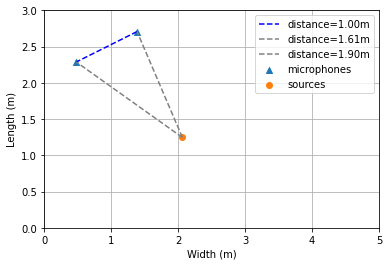

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]
<ipython-input-2-e2071cfca960>:75: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  targets = np.array([1000*denormalize(t, min_tdoa, max_tdoa) for t in targets])
<ipython-input-2-e2071cfca960>:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targ

Error mean: 0.179632011801732 Error std: 0.12003800926468497


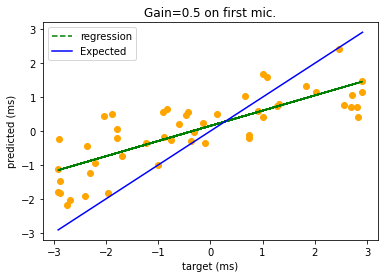

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

eps = np.finfo(np.float32).eps


def error(y_gt, y_pred):
    return np.sqrt((y_gt - y_pred)**2)

    
def eval_dataset(model, dataset, sort=True, plot_results=True):

    output_dicts = []
    
    for sample in tqdm(dataset):
        x, y = sample
        prediction = float(eval_model(model, x.unsqueeze(0)).numpy())
        gt = float(y["target"].numpy())
        error_val = error(gt, prediction)
        #print(f"ground_truth: {gt} prediction: {prediction}, error: {error_val}")
        
        y["prediction"] = prediction
        y["error"] = error_val
        y["signals"] = x
        output_dicts.append(y)
        
        if plot_results:
            plot_sample_results(y)
    
    if sort:       
        output_dicts.sort(key=lambda x: x["error"], reverse=True)
        
    print_dataset_stats(output_dicts)    
    
    return output_dicts

def plot_sample_results(d):
    delay_in_ms = d['mic_delays'][1]*1000
    print(f"Prediction {d['prediction']}, Error: {d['error']}")
    plot_mics_and_sources(d["room_dims"], d["mic_coordinates"], [d["source_coordinates"]])
    
    plt.show()

    #plot_microphone_signals(d["signals"], d, share_axis=False)
    
    plt.show()
    
    
def print_dataset_stats(output_dicts):
    errors = [d["error"] for d in output_dicts]
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    print(f"Error mean: {avg_error} Error std: {std_error}")
    

#     room_dims = eval(sample[0]["room_dims"])
#     mics = eval(sample[0]["mic_coordinates"])
#     sources = [eval(sample[0]["source_coordinates"])]
#     plot_mics_and_sources(room_dims, mics, sources)
#     plt.show()


def denormalize(normalized, min_v, max_v):
    return (normalized * (max_v-min_v) + min_v)

def scatter_prediction_vs_gt(output_dicts, label, plot_line=True):
    max_tdoa = 1/343
    min_tdoa = - max_tdoa
    predictions =  [d["prediction"] for d in output_dicts]
    targets =  [d["target"] for d in output_dicts]
    
    predictions = np.array([1000*denormalize(p, min_tdoa, max_tdoa) for p in predictions])
    targets = np.array([1000*denormalize(t, min_tdoa, max_tdoa) for t in targets])
    
    coef = np.polyfit(np.float32(targets),predictions,1, rcond = len(targets)*eps)
    poly1d_fn = np.poly1d(coef)
    plt.scatter(targets, predictions, color="orange")
    plt.plot(targets, poly1d_fn(targets), '--g', label="regression")
    
    plt.xlabel("target (ms)")
    plt.ylabel("predicted (ms)")
    
    if plot_line:
        expected_line = np.linspace(1000*min_tdoa, 1000*max_tdoa, len(predictions))
        plt.plot(expected_line, expected_line, label="Expected", color="b")
    plt.legend()
    plt.title(label)
    
    


output_dicts = eval_dataset(model, dataset, sort=True)

scatter_prediction_vs_gt(output_dicts, "Gain=0.5 on first mic.")
#scatter_prediction_vs_gt(output_dicts2, "gain=0.5 on first mic.", False)

